In [1]:
import jax
jax.config.update('jax_platform_name', 'cpu')

In [2]:
from entot.data.data import create_gaussians, create_gaussian_split
from entot.plotting.plots import plot_1D
from entot.models.models import NoiseOutsourcingModel, KantorovichGapModel
from entot.models.utils import DataLoader
import matplotlib.pyplot as plt
import h5py
from tqdm import tqdm

import numpy as np
import jax
import jax.numpy as jnp
from entot.nets import UNet
import jax
import optax

In [3]:
def h5py_to_dataset(path, img_size=64, batch_size: int = 64):
    with h5py.File(path, "r") as f:
        # List all groups
        print("Keys: %s" % f.keys())
        a_group_key = list(f.keys())[0]

        # Get the data
        data = list(f[a_group_key])
    
        #dataset = 2 * jnp.transpose(jnp.array(data) / 255., (0, 3, 1, 2))- 1
        dataset = jnp.array(data) / 255.
        dataset = jax.image.resize(dataset, (len(dataset), img_size, img_size, 3), method='bilinear')    

    return DataLoader(dataset, batch_size=batch_size)

In [33]:
with jax.default_device(jax.devices("cpu")[0]):
    handbags = h5py_to_dataset("../../../../data/handbag_128.hdf5", batch_size=1024)

Keys: <KeysViewHDF5 ['imgs']>


In [34]:
with jax.default_device(jax.devices("cpu")[0]):
    shoes = h5py_to_dataset("../../../../data/shoes_128.hdf5", batch_size=1024)

Keys: <KeysViewHDF5 ['imgs']>


In [35]:
source_batch= handbags(jax.random.PRNGKey(0))
target_batch= shoes(jax.random.PRNGKey(0))

In [36]:
source_reshaped = jnp.reshape(source_batch, (1024, -1))
target_reshaped = jnp.reshape(target_batch, (1024, -1))

In [37]:
from ott.solvers.linear import sinkhorn
from ott.problems.linear import linear_problem
from ott.geometry.pointcloud import PointCloud

geom = PointCloud(source_reshaped, target_reshaped)
out = sinkhorn.Sinkhorn()(linear_problem.LinearProblem(geom))

In [38]:
out.matrix.shape

(1024, 1024)

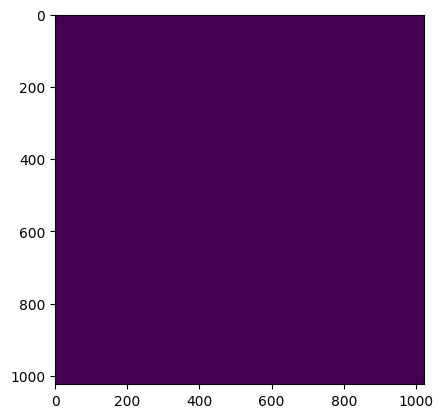

In [39]:
plt.imshow(out.matrix)

In [40]:
match = jnp.argmax(out.matrix, axis=1)

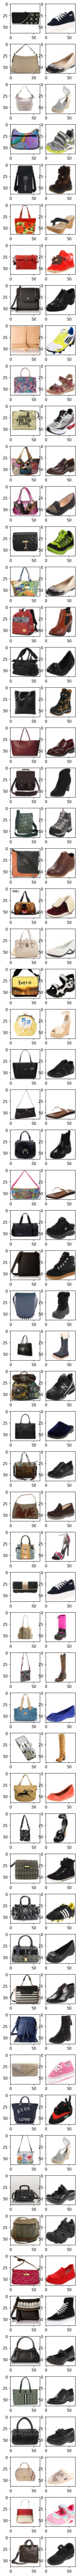

In [41]:
n_pairs = 64

fig, axes = plt.subplots(n_pairs, 2, figsize=(3, 120), dpi=150)

for i in range(n_pairs):
    axes[i][0].imshow(source_batch[i,...])
    axes[i][1].imshow(target_batch[match[i], ...])

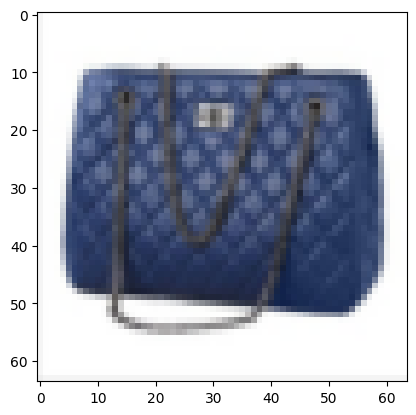

In [33]:
plt.imshow(source_batch[0,...])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


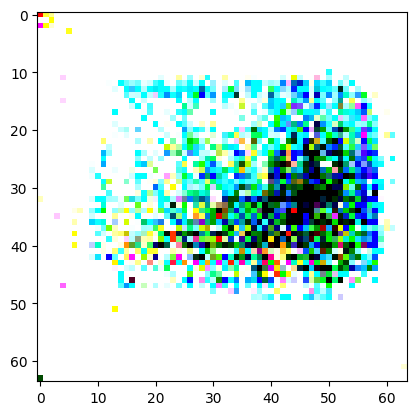

In [34]:
plt.imshow(jnp.squeeze(res[0,...]))